### Python imports

### Using Dask

#### Fargate cluster

In [8]:
# from dask_cloudprovider.aws import FargateCluster
# from dask.distributed import Client

# arn_role = ''
# dask_image = 'ghcr.io/vietnguyengit/vietnguyen-dask:main'

# cluster = FargateCluster(image=dask_image, 
#                          scheduler_timeout="60 minutes", 
#                          task_role_arn=arn_role,
#                          scheduler_cpu=4096, scheduler_mem=30720)
# cluster.scale(5)

# client = Client(cluster)
# display(client)

#### Local cluster

In [18]:
# import dask
# from dask.distributed import Client, LocalCluster

# dask_user = 'ec2-user'
# dask_address = 'localhost'
# dask_port = '0'

# with dask.config.set({'temporary_directory': f'/home/{dask_user}/dask/'}):
#     # set up cluster and workers
#     cluster = LocalCluster(n_workers=4, memory_limit='8GB', processes=True, 
#                            threads_per_worker=4, dashboard_address=f':{dask_port}', ip=dask_address)
#     client = Client(address=cluster.scheduler_address)

# print(f'http://{dask_address}'+':{port}/status'.format(port=client.scheduler_info().get('services').get('dashboard')))

http://localhost:44383/status


In [39]:
# cluster.close()
# client.close()

### Open Zarr and Visualisation

Use Dask if possible to run this section for performance improvement

In [3]:
%%time
import xarray as xr
import numpy as np

store_path = 's3://vietnguyen-dask/FargateCluster/all_argo/verybig.zarr'
data = xr.open_zarr(store_path)
data

CPU times: user 1.38 s, sys: 40.2 ms, total: 1.42 s
Wall time: 1.46 s


<xarray.Dataset>
Dimensions:                   (N_PROF: 23467, N_LEVELS: 3000)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/40)
    CONFIG_MISSION_NUMBER     (N_PROF) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    CYCLE_NUMBER              (N_PROF) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_CENTRE               (N_PROF) <U2 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_MODE                 (N_PROF) <U1 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_STATE_INDICATOR      (N_PROF) <U4 dask.array<chunksize=(1,), meta=np.ndarray>
    DC_REFERENCE              (N_PROF) <U32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                        ...
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    TEMP_ADJUSTED_QC          (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    TEMP_QC                   (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 dask.array<chunksize=(1,), meta=np.ndarray>
    WMO_INST_TYPE             (N_PROF) <U4 dask.array<chunksize=(1,), meta=np.ndarray>

In [4]:
import matplotlib.pyplot as plt
from datetime import datetime

def np_dt64_to_dt(in_datetime: np.datetime64) -> str:
    """Convert numpy datetime64 to datetime"""
    dt = datetime.fromtimestamp(in_datetime.astype(int) / 1e9)
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")

In [47]:
# Profile Plot
nprof = 21000 #Specify a profile to plot

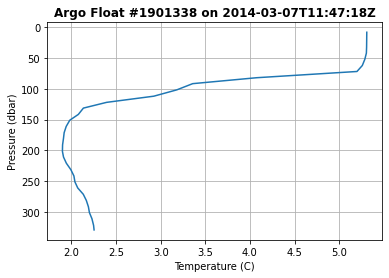

CPU times: user 326 ms, sys: 60.4 ms, total: 387 ms
Wall time: 359 ms


In [48]:
%%time
plt.plot(data.TEMP_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof])
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (dbar)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold');
plt.gca().invert_yaxis() #Flip the y-axis
plt.show()

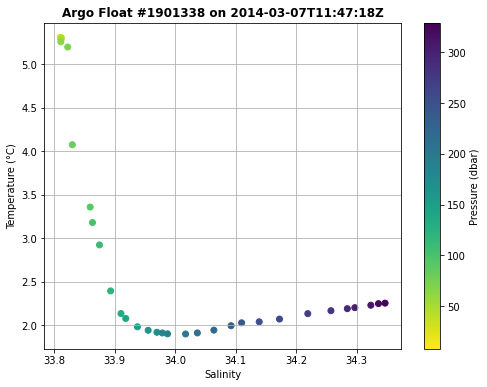

CPU times: user 489 ms, sys: 118 ms, total: 607 ms
Wall time: 511 ms


In [49]:
%%time
plt.figure(figsize=(8,6))
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof], c=data.PRES_ADJUSTED[nprof], cmap='viridis_r')
plt.xlabel('Salinity');
plt.ylabel('Temperature (°C)')
cbh = plt.colorbar();
cbh.set_label('Pressure (dbar)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold');
plt.show()

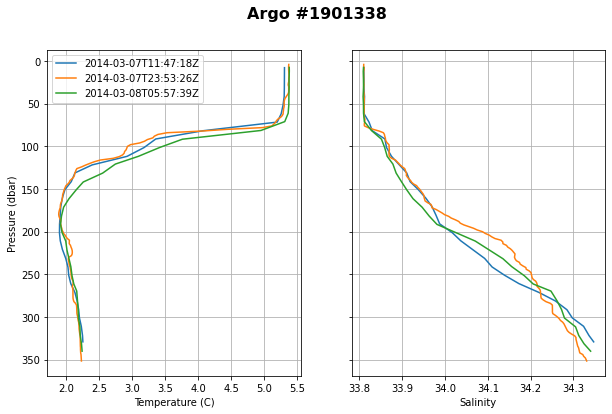

CPU times: user 661 ms, sys: 131 ms, total: 793 ms
Wall time: 1.02 s


In [50]:
%%time
# Profile Plot
# Subplot example
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(10,6))
ax1.plot(data.TEMP_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof], label=np_dt64_to_dt(data.JULD[nprof].values))
ax2.plot(data.PSAL_ADJUSTED[nprof], data.PRES_ADJUSTED[nprof])
nprof_mid = nprof + 3
ax1.plot(data.TEMP_ADJUSTED[nprof_mid], data.PRES_ADJUSTED[nprof_mid], label=np_dt64_to_dt(data.JULD[nprof_mid].values))
ax2.plot(data.PSAL_ADJUSTED[nprof_mid], data.PRES_ADJUSTED[nprof_mid])
nprof_last = nprof_mid + 3 # Last profile
ax1.plot(data.TEMP_ADJUSTED[nprof_last], data.PRES_ADJUSTED[nprof_last], label=np_dt64_to_dt(data.JULD[nprof_last].values))
ax2.plot(data.PSAL_ADJUSTED[nprof_last], data.PRES_ADJUSTED[nprof_last])
ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlabel('Temperature (C)')
ax2.set_xlabel('Salinity')
ax1.invert_yaxis()
ax1.legend()
# Add some gridlines
ax1.grid()
ax2.grid()
# Add a super title
fig.suptitle('Argo #%d' % data.PLATFORM_NUMBER[nprof].values, fontweight='bold', fontsize=16)
plt.show()

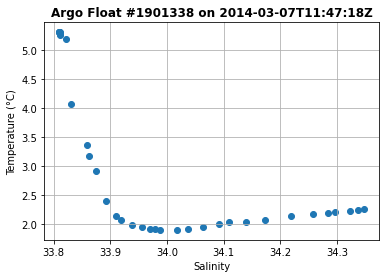

CPU times: user 474 ms, sys: 87.1 ms, total: 562 ms
Wall time: 463 ms


In [51]:
%%time
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof])
plt.xlabel('Salinity')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold')
plt.show()

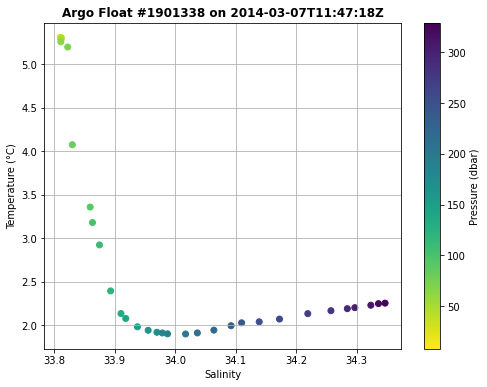

CPU times: user 532 ms, sys: 97.4 ms, total: 629 ms
Wall time: 554 ms


In [52]:
%%time
plt.figure(figsize=(8,6))
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof], c=data.PRES_ADJUSTED[nprof], cmap='viridis_r')
plt.xlabel('Salinity');
plt.ylabel('Temperature (°C)')
cbh = plt.colorbar();
cbh.set_label('Pressure (dbar)')
plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold')
plt.show()